# раздел

In [3]:
import pandas as pd
import numpy as np
import re
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import torch

In [4]:
df = pd.read_csv('/content/drive/MyDrive/JOB_LIST.csv', low_memory=False, encoding_errors= 'replace')

In [5]:
df = df.drop_duplicates()
len(df)

1002006

In [ ]:
print(df.job_title.unique()[:100])

['Старший инспектор отдела пособий,субсидий и компенсаций'
 'Инспектор отдела муниципальных закупок и имущественных отношений'
 'Ведущий геолог' 'Геолог 1 категории' 'Начальник горного отряда'
 'Геолог горного отряда'
 'Ведущий геолог камеральной группы, старший геолог горного отряда проекты: детальные поиски и разведка с применением колонкового бурения и поверхностных горных выработок золоторудного месторождения в бассейне р.нерунда. исполняемые обязанности: проектирование геологоразведочных работ; сбор и анализ геологоразведочной и маркшейдерской документации; аналитика и компьютерная обработка полученных материалов'
 'Ведущий геолог камеральной группы, главный геолог, заместитель главного геолога'
 'Заместитель начальника отдела экономики, промышленности и инвестиций'
 'Заместитель генерального директора, начальник финансового отдела'
 'Заместитель генерального директора'
 'Участковый геолог, геолог ii категории, руководитель бвр-геолог поискового отряда, ведущий геолог экспедиции'


In [6]:
df_next = df
df_next.head()

,job_title
0,"Старший инспектор отдела пособий,субсидий и ко..."
1,Инспектор отдела муниципальных закупок и имуще...
2,Ведущий геолог
3,Геолог 1 категории
5,Начальник горного отряда


In [7]:
df_next['job_title'] = df_next['job_title'].apply(lambda x: '' if isinstance(x, float) else x)

In [8]:
df_next = df_next.applymap(lambda x: x.lower() if isinstance(x, str) else x)

<ipython-input-8-4e851cbab69f>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_next = df_next.applymap(lambda x: x.lower() if isinstance(x, str) else x)


In [9]:
df_next2 = df_next
df_next2.head()

,job_title
0,"старший инспектор отдела пособий,субсидий и ко..."
1,инспектор отдела муниципальных закупок и имуще...
2,ведущий геолог
3,геолог 1 категории
5,начальник горного отряда


In [10]:
def clean_text(text):
    if isinstance(text, str):
        # Удаление неразрывных пробелов \xa0
        text = text.replace('\xa0', ' ')

        # Удаление всех символов кроме букв и чисел
        text = re.sub(r'[^a-zA-Zа-яА-Я0-9]', ' ', text)

        # Удаление лишних пробелов
        text = re.sub(r'\s+', ' ', text).strip()

        return text
    return text

# Применяем сначала очистку, затем токенизацию к столбцу 'job_title'
df_next['job_title'] = df_next['job_title'].apply(clean_text)
# Применение функции к столбцу 'job_title'
df_next2['job_title'] = df_next2['job_title'].apply(clean_text)

#BERT

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, BertModel
import torch
import numpy as np

# Проверим, доступен ли GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Загрузка токенизатора и модели BERT
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = BertModel.from_pretrained("cointegrated/rubert-tiny2").to(device)

# Размер батча: можно уменьшить до 16, если память ограничена
batch_size = 16

# Путь для сохранения результатов
output_path = 'embeddings_output.csv'

# Открываем файл для записи результатов
with open(output_path, 'w') as f:
    f.write('job_title,embeddings\n')  # Заголовки для CSV

    # Цикл для батчевой обработки
    for i in range(0, len(df_next), batch_size):
        # Получаем батч данных
        batch_texts = df_next['job_title'].tolist()[i:i+batch_size]

        # Токенизация текстов
        tokens = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=128)

        # Перемещаем токены на устройство (GPU или CPU)
        tokens = {key: val.to(device) for key, val in tokens.items()}

        # Получение эмбеддингов с помощью модели BERT
        with torch.no_grad():
            outputs = model(**tokens)

        # Получение скрытых состояний
        hidden_states = outputs.last_hidden_state

        # Усреднение эмбеддингов токенов для каждого предложения
        sentence_embeddings = torch.mean(hidden_states, dim=1).cpu().numpy()

        # Для каждого предложения сохраняем результат
        for text, embedding in zip(batch_texts, sentence_embeddings):
            embedding_str = ' '.join(map(str, embedding))  # Преобразуем в строку
            f.write(f'"{text}","{embedding_str}"\n')

        # Печать прогресса
        if i % 1000 == 0:
            print(f"Обработано {i} записей из {len(df_next)}")

print(f"Результаты сохранены в {output_path}")


Обработано 0 записей из 1002006
Обработано 2000 записей из 1002006
Обработано 4000 записей из 1002006
Обработано 6000 записей из 1002006
Обработано 8000 записей из 1002006
Обработано 10000 записей из 1002006
Обработано 12000 записей из 1002006
Обработано 14000 записей из 1002006
Обработано 16000 записей из 1002006
Обработано 18000 записей из 1002006
Обработано 20000 записей из 1002006
Обработано 22000 записей из 1002006
Обработано 24000 записей из 1002006
Обработано 26000 записей из 1002006
Обработано 28000 записей из 1002006
Обработано 30000 записей из 1002006
Обработано 32000 записей из 1002006
Обработано 34000 записей из 1002006
Обработано 36000 записей из 1002006
Обработано 38000 записей из 1002006
Обработано 40000 записей из 1002006
Обработано 42000 записей из 1002006
Обработано 44000 записей из 1002006
Обработано 46000 записей из 1002006
Обработано 48000 записей из 1002006
Обработано 50000 записей из 1002006
Обработано 52000 записей из 1002006
Обработано 54000 записей из 1002006


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Параметры
batch_size = 10000  # Размер батча
num_clusters = 1500  # Количество кластеров
max_rows = 1000000
# Инициализация K-Means модели
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Переменная для хранения результатов кластеров
cluster_results = []

# Счетчик обработанных строк
processed_rows = 0

# Общий размер данных для контроля (можно вычислить заранее или получить из данных)
total_rows = sum(1 for row in open('embeddings_output.csv')) - 1  # Убираем заголовок

# Чтение данных батчами
for chunk in pd.read_csv('embeddings_output.csv', sep=',', chunksize=batch_size, on_bad_lines='skip', nrows=max_rows):
    # Преобразуем строковые эмбеддинги обратно в числовые массивы
    chunk['embeddings'] = chunk['embeddings'].apply(lambda x: np.fromstring(x, sep=' '))

    # Преобразуем эмбеддинги в массив numpy для кластеризации
    embeddings_matrix = np.vstack(chunk['embeddings'].values)

    # Применение K-Means для текущего батча
    chunk_clusters = kmeans.fit_predict(embeddings_matrix)

    # Добавляем метки кластеров к текущему батчу
    chunk['cluster'] = chunk_clusters

    # Сохраняем результаты кластеризации для данного батча
    cluster_results.append(chunk[['job_title', 'embeddings', 'cluster']])

    # Увеличиваем счетчик обработанных строк
    processed_rows += len(chunk)

    # Вывод прогресса
    print(f"Обработано {processed_rows} строк из {total_rows} ({(processed_rows / total_rows) * 100:.2f}%)")

# Объединяем все результаты кластеризации
df_results = pd.concat(cluster_results, ignore_index=True)

# Вывод первых результатов
print(df_results.head())

# Группируем профессии по кластерам
for cluster_num in range(num_clusters):
    print(f"\nПрофессии в кластере {cluster_num}:")
    print(df_results[df_results['cluster'] == cluster_num]['job_title'].values[:10])


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Обработано 1000 строк из 1002006 (0.10%)
                                           job_title  \
0  старший инспектор отдела пособий,субсидий и ко...   
1  инспектор отдела муниципальных закупок и имуще...   
2                                     ведущий геолог   
3                                 геолог 1 категории   
4                           начальник горного отряда   

                                          embeddings  cluster  
0  [0.24927843, -0.14122461, -0.9948604, -1.44265...        8  
1  [1.1223404, -0.48873475, -0.16994432, -0.78415...        5  
2  [-0.39250728, 0.05870753, 0.2733877, -0.255757...        1  
3  [0.5496922, -0.3416528, -0.7355586, 0.05531096...        0  
4  [0.4727174, -0.4102038, -0.10539828, -0.673286...        5  

Профессии в кластере 0:
['геолог 1 категории' 'секретарь ( приёмной )'
 'инженер по метрологии 2 категории' 'бухгалтер 1 категории'
 'бухгалтер 2,1 категорий, главный специалист'
 'контролер-кассир 2 категории' 'казначей-ведущий специали

Кластер 0: администратор 1 категории
Кластер 1: администратор
Кластер 2: электрослесарь дежурный и по ремонту оборудования
Кластер 3: ведущий инженер-механик
Кластер 4: менеджер-кассир
Кластер 5: специалист операционного отдела
Кластер 6: специалист по обслуживанию банкоматов
Кластер 7: заместитель начальника оур
Кластер 8: главный специалист – андеррайтер отдела продаж и контроля дмс, нс корпоративных клиентов
Кластер 9: монтажер


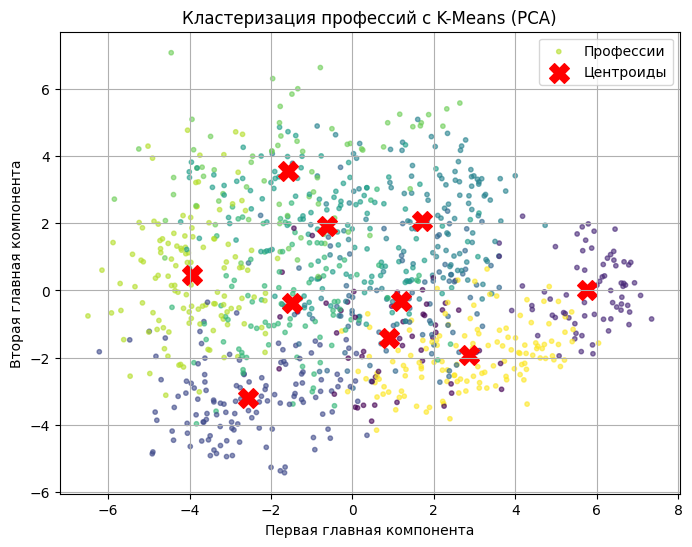

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

'''
+====+
Репрезентативные центроиды
+====+
'''

centroids = kmeans.cluster_centers_

# Найдем репрезентативные тексты для каждого кластера
representative_texts = []

for cluster_num in range(num_clusters):
    # Выбираем тексты, принадлежащие текущему кластеру
    cluster_texts = df_results[df_results['cluster'] == cluster_num]

    # Выбираем эмбеддинги этих текстов
    cluster_embeddings = np.vstack(cluster_texts['embeddings'].values)

    # Считаем расстояние от каждого эмбеддинга до центроида
    distances = np.linalg.norm(cluster_embeddings - centroids[cluster_num], axis=1)

    # Находим индекс самого близкого текста
    closest_idx = np.argmin(distances)

    # Добавляем репрезентативный текст для текущего кластера
    representative_texts.append(cluster_texts.iloc[closest_idx]['job_title'])

# Показательные значения для каждого кластера
for i, text in enumerate(representative_texts):
    print(f"Кластер {i}: {text}")

'''
+====+
Визуализация кластеров и центроидов
+====+
'''

pca = PCA(n_components=2)
all_embeddings = np.vstack(df_results['embeddings'].apply(np.array).values)
all_data_reduced = pca.fit_transform(all_embeddings)
centroids_reduced = pca.transform(centroids)

df_results[['pca_x', 'pca_y']] = all_data_reduced

plt.figure(figsize=(8, 6))
plt.scatter(df_results['pca_x'], df_results['pca_y'], c=df_results['cluster'], cmap='viridis', s=10, alpha=0.6, label='Профессии')
plt.scatter(centroids_reduced[:, 0], centroids_reduced[:, 1], c='red', s=200, marker='X', label='Центроиды')
plt.title('Кластеризация профессий с K-Means (PCA)')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.legend()
plt.grid(True)
plt.show()